# Project: Identify Customer Segments

In this project, I will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that I will use has been provided by Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [808]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    
import operator
from sklearn.preprocessing import LabelEncoder
import re

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. I will use this information to cluster the general population into groups with similar demographic properties. Then, I will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, I will load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary.

In [809]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [810]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows)
print ("Dataset has {} rows, {} columns".format(*azdias.shape))
azdias.head(5)

Dataset has 891221 rows, 85 columns


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

 ## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. I will use this file in making cleaning decisions during this stage of the project. First of all,I will assess the demographics data in terms of missing data.

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. I'll need to do a little bit of parsing to make use of it to identify and clean the data. I'll then convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. I want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [811]:
print('Total number of naturally missing values are {}'.format(azdias.isnull().sum().sum()))

Total number of naturally missing values are 4896838


In [812]:
# Identify missing or unknown data values and convert them to NaNs.
values = ['-1','0','1','2','3','4','5','6','7','8','9']
for column in range(85):
    missing_values = feat_info.iloc[column][3]
    missing_values = missing_values.strip('[')
    missing_values = missing_values.strip(']')
    missing_values = missing_values.split(sep=',')
    for i in range(len(missing_values)):
        if missing_values[i] in values:
                missing_values[i] = int(missing_values[i])
    if(missing_values!=['']):
        azdias = azdias.replace({feat_info.iloc[column][0]: missing_values}, np.nan)

In [813]:
print('Total number of missing values after identifying missing or unknown and converting them to NaNs:  {}'.format(azdias.isnull().sum().sum()))

Total number of missing values after identifying missing or unknown and converting them to NaNs:  8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. I will use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. I'll then identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project I just remove them from the dataframe.

I also want to explore whether for the remaining features, are there any patterns in which columns have, or share, missing data?

In [814]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_values_per_feature =(azdias.isnull().sum()/891221).sort_values(ascending=False)*100
missing_values_per_feature

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

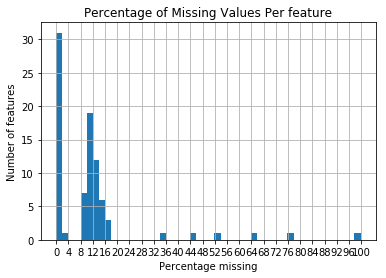

In [815]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_values_per_feature,bins=50)
plt.title("Percentage of Missing Values Per feature");
plt.ylabel("Number of features");
plt.xlabel("Percentage missing");
plt.xticks(np.arange(0, 101, step=4))
plt.grid()

As we can see that columns with missing values percentage greater than 18% are outlier, So, we will remove those columns.

In [816]:
# Remove the outlier columns from the dataset. (I'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier_column = []
for column in range(85):
    current_column=missing_values_per_feature.index[column]
    percent_missing_current_column=missing_values_per_feature[column]
    if percent_missing_current_column >18:
        outlier_column.append(current_column)

In [817]:
#printing the outlier column
outlier_column


['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

We can see that there are 6 outlier columns. Let's drop them.

In [818]:
#removing the outlier column from the dataset
azdias = azdias.drop(columns=outlier_column)

#### Discussion 1.1.2: Assess Missing Data in Each Column

>The column with more than 18% missing values were considered outlier and so they were dropped.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, I'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. I'll then divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. I'll then select at least five of these columns and compare the distribution of values.
- I'll use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.

Depending on what I observe in my comparison, this will have implications on how I approach my conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then I could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then I should make a note on those data as special. **I will continue my analysis for now using just the subset of the data with few or no missing values.**

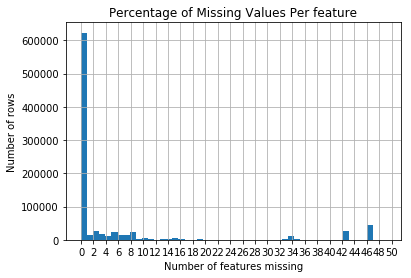

In [819]:
# How much data is missing in each row of the dataset?
plt.hist(azdias.isnull().sum(axis=1),bins=50)
plt.title("Percentage of Missing Values Per feature");
plt.ylabel("Number of rows");
plt.xlabel("Number of features missing");
plt.xticks(np.arange(0, 51, step=2))
plt.grid()

From the above plot , we can easily conclude that we can divide the dataset into 2 parts, one part having less than 5 features missing and one part having more than or equal to 2 features missing.

In [820]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_low = azdias[azdias.isnull().sum(axis=1) <= 2]
azdias_high = azdias[azdias.isnull().sum(axis=1) > 2]

In [821]:
#Finding the columns having zero missing values
zero_missing=[]
for i in range(79):
    if(missing_values_per_feature[i]==0):
        zero_missing.append(missing_values_per_feature.index[i])
zero_missing 

['FINANZTYP',
 'GREEN_AVANTGARDE',
 'FINANZ_HAUSBAUER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_ANLEGER',
 'FINANZ_SPARER',
 'FINANZ_MINIMALIST',
 'ANREDE_KZ',
 'FINANZ_VORSORGER',
 'SEMIO_FAM',
 'SEMIO_SOZ',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT']

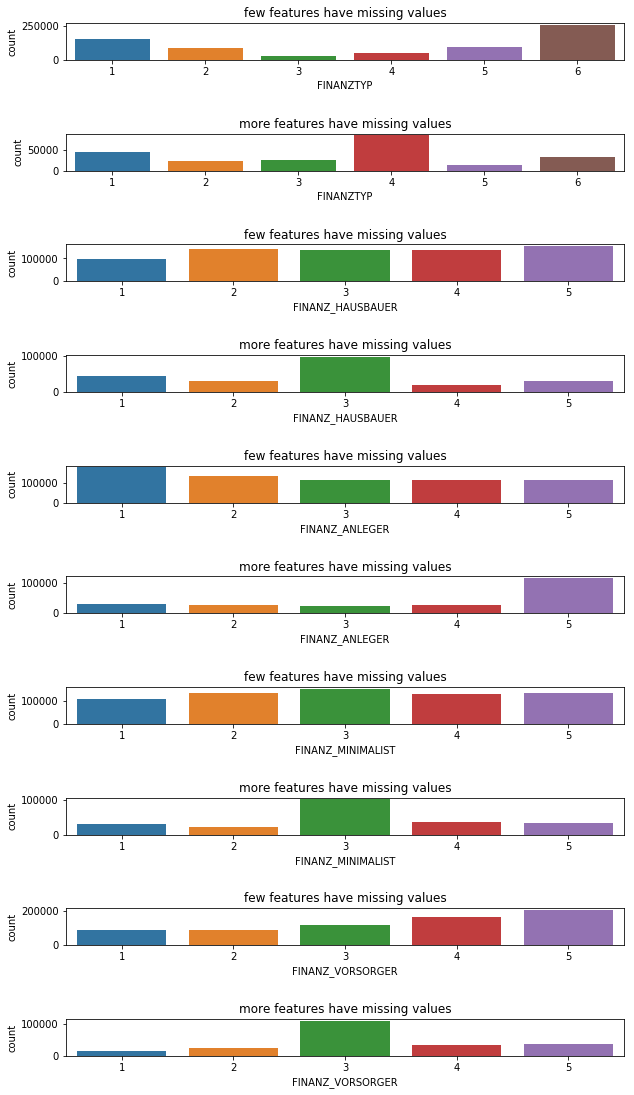

In [822]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
fig, axs = plt.subplots(10, figsize=(10,19))
fig.subplots_adjust(hspace = 2, wspace=.2)
for i in range(10):
    if(i%2==0):
        sns.countplot(azdias_low[zero_missing[i]], ax=axs[i])
        axs[i].set_title('few features have missing values')
        sns.countplot(azdias_high[zero_missing[i]], ax=axs[i+1])
        axs[i+1].set_title('more features have missing values')
    continue

#### Discussion 1.1.3: Assess Missing Data in Each Row

In this section, we have devided the datasets into 2 parts, one having lower numbers of missing values(5 or less features missing) and one having higher number of missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which I can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, I need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, I will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether I will keep, drop, or re-encode each. Then, in the last part, I will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here.

In [823]:
# How many features are there of each data type?
features = list(azdias.columns.values)
feat_info = feat_info[feat_info['attribute'].isin(features)]

feat_info['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, I can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, I will create a dummy variable.
- For multi-level categoricals (three or more values), I'll just drop them from the analysis.

In [824]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_variables = feat_info[feat_info['type'] == 'categorical']
categorical_variables

attribute information_level         type missing_or_unknown
2          ANREDE_KZ            person  categorical             [-1,0]
3      CJT_GESAMTTYP            person  categorical                [0]
10         FINANZTYP            person  categorical               [-1]
12   GFK_URLAUBERTYP            person  categorical                 []
13  GREEN_AVANTGARDE            person  categorical                 []
17   LP_FAMILIE_FEIN            person  categorical                [0]
18   LP_FAMILIE_GROB            person  categorical                [0]
19    LP_STATUS_FEIN            person  categorical                [0]
20    LP_STATUS_GROB            person  categorical                [0]
21  NATIONALITAET_KZ            person  categorical             [-1,0]
38       SHOPPER_TYP            person  categorical               [-1]
39           SOHO_KZ            person  categorical               [-1]
41          VERS_TYP            person  categorical               [-1]
42          ZABEOTYP            person  categorical             [-1,9]
52       GEBAEUDETYP          building  categorical             [-1,0]
55       OST_WEST_KZ          building  categorical               [-1]
57   CAMEO_DEUG_2015     microcell_rr4  categorical             [-1,X]
58    CAMEO_DEU_2015     microcell_rr4  categorical               [XX]

In [825]:
# separating the multi level and binary categorical variable
multi_level = []
binary = []
for feature in list(categorical_variables['attribute']):
    if len(azdias[feature].value_counts()) > 2:
        multi_level.append(feature)
    else:
        binary.append(feature)
            

In [826]:
multi_level

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

I will be droping the multilevel categorical variables. **I am carrying out this analysis on the subset of the data with few or no missing values.**

In [827]:
#Dropping the multi level categorical variables
for column in multi_level:
    azdias_low=azdias_low.drop(column, axis=1)

In [828]:
# Re-encoding all the binary categorical variable(s)(both numeric and non numeric) to be kept in the analysis.
azdias_low_dummies = pd.get_dummies(data=azdias_low, columns=binary, prefix=binary)
azdias_low_dummies.head()

ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
1                   1.0                  1              5                 2   
2                   3.0                  1              4                 1   
4                   3.0                  4              3                 4   
5                   1.0                  3              1                 5   
6                   2.0                  1              5                 1   

   FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  HEALTH_TYP  \
1               5                      4                 5         3.0   
2               2                      3                 5         3.0   
4               1                      3                 2         3.0   
5               2                      2                 5         3.0   
6               5                      4                 3         2.0   

   LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB      ...        ANREDE_KZ_1  \
1                 21.0                  6.0      ...                  0   
2                  3.0                  1.0      ...                  0   
4                 32.0                 10.0      ...                  1   
5                  8.0                  2.0      ...                  0   
6                  2.0                  1.0      ...                  0   

   ANREDE_KZ_2  GREEN_AVANTGARDE_0  GREEN_AVANTGARDE_1  SOHO_KZ_0.0  \
1            1                   1                   0            0   
2            1                   0                   1            1   
4            0                   1                   0            1   
5            1                   1                   0            1   
6            1                   1                   0            1   

   SOHO_KZ_1.0  VERS_TYP_1.0  VERS_TYP_2.0  OST_WEST_KZ_O  OST_WEST_KZ_W  
1            1             0             1              0              1  
2            0             1             0              0              1  
4            0             0             1              0              1  
5            0             0             1              0              1  
6            0             1             0              0              1  

[5 rows x 71 columns]

#### Discussion 1.2.1: Re-Encode Categorical Features

>I dropped the multi level categorical variables and re-encoded all the other binary categorical variables(both numeric and non numeric)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, I have created two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [829]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
DECADE = []
value1 = list(azdias_low_dummies['PRAEGENDE_JUGENDJAHRE'])
for i in range (len(list(azdias_low_dummies['PRAEGENDE_JUGENDJAHRE']))):
    value = value1[i]
    if value in [1,2]:
        DECADE.append(1)
    elif value in [3,4]:
        DECADE.append(2)
    elif value in [5,6,7]:
        DECADE.append(3)
    elif value in [8,9]:
        DECADE.append(4)
    elif value in [10,11,12,13]:
        DECADE.append(5)
    elif value in [14,15]:
        DECADE.append(6)
    else:
        DECADE.append(np.nan)

In [830]:
MOVEMENT =[]
for i in range (len(value1)):
    value = value1[i]
    if value in [2,4,6,7,9,11,13,15]:
        MOVEMENT.append(1)
    elif value in [1,3,5,8,10,12,14]:
        MOVEMENT.append(2)
    else:
        MOVEMENT.append(np.nan)



In [831]:
#Adding the two new features and dropping 'PRAEGENDE_JUGENDJAHRE'
azdias_low_dummies["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = MOVEMENT
azdias_low_dummies["PRAEGENDE_JUGENDJAHRE_DECADE"] = DECADE
azdias_low_dummies=azdias_low_dummies.drop("PRAEGENDE_JUGENDJAHRE", axis=1)

In [832]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
WEALTH = []
value2 = list(azdias_low_dummies['CAMEO_INTL_2015'])
for i in range (len(value2)):
    value=value2[i]
    if(type(value)!=float):
        WEALTH.append(int(value[0]))
    else:
        WEALTH.append(np.nan)

In [833]:
LIFE_STAGE =[]
for i in range (len(value2)):
    value=value2[i]
    if(type(value)!=float):
        LIFE_STAGE.append(int(value[1]))
    else:
        LIFE_STAGE.append(np.nan)

In [834]:
#Adding the two new features and dropping "CAMEO_INTL_2015"
azdias_low_dummies["CAMEO_INTL_2015_WEALTH"] = WEALTH
azdias_low_dummies["CAMEO_INTL_2015_LIFE_STAGE"] = LIFE_STAGE
azdias_low_dummies=azdias_low_dummies.drop("CAMEO_INTL_2015", axis=1)

In [835]:
azdias_low_dummies.head()

ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
1                   1.0                  1              5                 2   
2                   3.0                  1              4                 1   
4                   3.0                  4              3                 4   
5                   1.0                  3              1                 5   
6                   2.0                  1              5                 1   

   FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  HEALTH_TYP  \
1               5                      4                 5         3.0   
2               2                      3                 5         3.0   
4               1                      3                 2         3.0   
5               2                      2                 5         3.0   
6               5                      4                 3         2.0   

   LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB             ...              \
1                 21.0                  6.0             ...               
2                  3.0                  1.0             ...               
4                 32.0                 10.0             ...               
5                  8.0                  2.0             ...               
6                  2.0                  1.0             ...               

   SOHO_KZ_0.0  SOHO_KZ_1.0  VERS_TYP_1.0  VERS_TYP_2.0  OST_WEST_KZ_O  \
1            0            1             0             1              0   
2            1            0             1             0              0   
4            1            0             0             1              0   
5            1            0             0             1              0   
6            1            0             1             0              0   

   OST_WEST_KZ_W  PRAEGENDE_JUGENDJAHRE_MOVEMENT  \
1              1                             2.0   
2              1                             1.0   
4              1                             2.0   
5              1                             2.0   
6              1                             2.0   

   PRAEGENDE_JUGENDJAHRE_DECADE  CAMEO_INTL_2015_WEALTH  \
1                           6.0                       5   
2                           6.0                       2   
4                           4.0                       4   
5                           2.0                       5   
6                           5.0                       2   

   CAMEO_INTL_2015_LIFE_STAGE  
1                           1  
2                           4  
4                           3  
5                           4  
6                           2  

[5 rows x 73 columns]

#### Discussion 1.2.2: Engineer Mixed-Type Features

I engineered 2 new features each for 'PRAEGENDE_JUGENDJAHRE' **and** "CAMEO_INTL_2015".

>"PRAEGENDE_JUGENDJAHRE_MOVEMENT" : 1 for AVANTGARDE and 2 for MAINSTREAM

>"PRAEGENDE_JUGENDJAHRE_DECADE" : 1 for 1940s, 2 for 1950s, 3 for 1960s, 4 for 1970s, 5 for 1980s and 6 for 1990s 

>"CAMEO_INTL_2015_WEALTH" : 1 for WEALTHY, 2 for PROSPEROUS, 3 for COMFORTABLE, 4 for LESS AFFLUENT and 5 for POORER

>"CAMEO_INTL_2015_LIFE_STAGE" : 1 for Pre-Family Couples & Singles, 2 for Young Couples With Children, 3 for Families With School Age Children, 4 for Older Families &  Mature Couples and 5 for Elders In Retirement

### Step 1.3: Create a Cleaning Function

Even though I've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that I'll need to perform the same cleaning steps on the customer demographics data. In this substep, I'll complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, I can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [836]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # Load in the feature summary file.
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    # convert missing value codes into NaNs, ...
    values = ['-1','0','1','2','3','4','5','6','7','8','9']
    for column in range(85):
        missing_values = feat_info.iloc[column][3]
        missing_values = missing_values.strip('[')
        missing_values = missing_values.strip(']')
        missing_values = missing_values.split(sep=',')
        for i in range(len(missing_values)):
            if missing_values[i] in values:
                missing_values[i] = int(missing_values[i])
        if(missing_values!=['']):
            df = df.replace({feat_info.iloc[column][0]: missing_values}, np.nan)
    # Perform an assessment of how much missing data there is in each column of the
    # dataset.
    missing_values_per_feature = df.isnull().sum()
    missing_values_per_feature =missing_values_per_feature/ 891221
    missing_values_per_feature=missing_values_per_feature.sort_values()*100
    # Remove the outlier columns from the dataset. (You'll perform other data
    # engineering tasks such as re-encoding and imputation later.)
    outlier_column = []
    for column in range(85):
        current_column=df.columns.values[column]
        percent_missing_current_column=missing_values_per_feature[column]
        if percent_missing_current_column >18:
            outlier_column.append(current_column)
    
    
    # remove selected columns and rows, ...
    df = df.drop(columns=outlier_column)
    df_low = df[df.isnull().sum(axis=1) < 5]


    # select, re-encode, and engineer column values.

    categorical_variables = feat_info[feat_info['type'] == 'categorical']
    multi_level = []
    binary = []
    for feature in list(categorical_variables['attribute']):
        if len(df[feature].value_counts()) > 2:
            multi_level.append(feature)
        else:
            binary.append(feature)
    #Dropping the multi level categorical variables
    for column in multi_level:
        df_low=df_low.drop(column, axis=1)
        
    # Re-encode categorical variable(s) to be kept in the analysis.
    df_low_dummies = pd.get_dummies(data=df_low, columns=binary, prefix=binary)
    df_low_dummies.head()
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    MOVEMENT = []
    value1 = list(df_low_dummies['PRAEGENDE_JUGENDJAHRE'])
    for i in range (len(list(df_low_dummies['PRAEGENDE_JUGENDJAHRE']))):
        value = value1[i]
        if value in [1,2]:
            MOVEMENT.append(1)
        elif value in [3,4]:
            MOVEMENT.append(2)
        elif value in [5,6,7]:
            MOVEMENT.append(3)
        elif value in [8,9]:
            MOVEMENT.append(4)
        elif value in [10,11,12,13]:
            MOVEMENT.append(5)
        elif value in [14,15]:
            MOVEMENT.append(6)
        else:
            MOVEMENT.append(np.nan)
    DECADE =[]
    for i in range (len(value1)):
        value = value1[i]
        if value in [2,4,6,7,9,11,13,15]:
            DECADE.append(0)
        elif value in [1,3,5,8,10,12,14]:
            DECADE.append(1)
        else:
            DECADE.append(np.nan)
    df_low_dummies["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = MOVEMENT
    df_low_dummies["PRAEGENDE_JUGENDJAHRE_DECADE"] = DECADE
    df_low_dummies=df_low_dummies.drop("PRAEGENDE_JUGENDJAHRE", axis=1)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    WEALTH = []
    value2 = list(df_low_dummies['CAMEO_INTL_2015'])
    for i in range (len(value2)):
        value=value2[i]
        if(type(value)!=float):
            WEALTH.append(int(value[0]))
        else:
            WEALTH.append(np.nan)
    LIFE_STAGE =[]
    for i in range (len(value2)):
        value=value2[i]
        if(type(value)!=float):
            LIFE_STAGE.append(int(value[1]))
        else:
            LIFE_STAGE.append(np.nan)
            
    df_low_dummies["CAMEO_INTL_2015_WEALTH"] = WEALTH
    df_low_dummies["CAMEO_INTL_2015_LIFE_STAGE"] = LIFE_STAGE
    df_low_dummies=df_low_dummies.drop("CAMEO_INTL_2015", axis=1)
    
    # Return the cleaned dataframe.
    return df_low_dummies
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features.In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to my data, make sure that you've cleaned the DataFrame of the remaining missing values. I'll replace all missing values with mode. 

- [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance for scaling each feature to mean 0 and standard deviation 1.

- For these classes, I'll make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time.

In [837]:
# Apply feature scaling to the general population demographics data.
#imputing missing values with the mode
azdias_low_dummies[list(azdias_low_dummies.columns)] = azdias_low_dummies[list(azdias_low_dummies.columns)].fillna(azdias_low_dummies.mode().iloc[0])
scaler = StandardScaler()
azdias_low_dummies[list(azdias_low_dummies.columns)] = scaler.fit_transform(azdias_low_dummies[list(azdias_low_dummies.columns)])

In [838]:
azdias_low_dummies.head()

ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
1             -1.742284          -1.518333       1.584388         -1.052653   
2              0.193020          -1.518333       0.905963         -1.773152   
4              0.193020           0.681366       0.227538          0.388344   
5             -1.742284          -0.051867      -1.129311          1.108842   
6             -0.774632          -1.518333       1.584388         -1.773152   

   FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  HEALTH_TYP  \
1        1.521225               1.046959          1.332026    1.044315   
2       -0.538858               0.320062          1.332026    1.044315   
4       -1.225553               0.320062         -0.844853    1.044315   
5       -0.538858              -0.406835          1.332026    1.044315   
6        1.521225               1.046959         -0.119227   -0.279180   

   LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB             ...              \
1             0.378678             0.273136             ...               
2            -1.078953            -1.047132             ...               
4             1.269453             1.329349             ...               
5            -0.674056            -0.783078             ...               
6            -1.159933            -1.047132             ...               

   SOHO_KZ_0.0  SOHO_KZ_1.0  VERS_TYP_1.0  VERS_TYP_2.0  OST_WEST_KZ_O  \
1   -10.839373    10.839373     -0.942138      0.942138      -0.526576   
2     0.092256    -0.092256      1.061416     -1.061416      -0.526576   
4     0.092256    -0.092256     -0.942138      0.942138      -0.526576   
5     0.092256    -0.092256     -0.942138      0.942138      -0.526576   
6     0.092256    -0.092256      1.061416     -1.061416      -0.526576   

   OST_WEST_KZ_W  PRAEGENDE_JUGENDJAHRE_MOVEMENT  \
1       0.526576                        0.546393   
2       0.526576                       -1.830185   
4       0.526576                        0.546393   
5       0.526576                        0.546393   
6       0.526576                        0.546393   

   PRAEGENDE_JUGENDJAHRE_DECADE  CAMEO_INTL_2015_WEALTH  \
1                      1.143731                1.166730   
2                      1.143731               -0.879379   
4                     -0.227754                0.484694   
5                     -1.599239                1.166730   
6                      0.457988               -0.879379   

   CAMEO_INTL_2015_LIFE_STAGE  
1                   -1.260429  
2                    0.748259  
4                    0.078696  
5                    0.748259  
6                   -0.590866  

[5 rows x 73 columns]

### Discussion 2.1: Apply Feature Scaling

Before applying feature scaling , I replaced the missing values with the mode values of respective column.

### Step 2.2: Perform Dimensionality Reduction

On my scaled data, I am now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, I'll not set any parameters (so all components are computed) to see the general trend in variability.
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. I'll try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what I find, I'll select a value for the number of transformed features I'll retain for the clustering part of the project.
- Once I've made a choice for the number of components to keep, I'll make sure I re-fit a PCA instance to perform the decided-on transformation.

In [839]:
# Apply PCA to the data.
pca = PCA()
azdias_low_pca = pca.fit_transform(azdias_low_dummies)

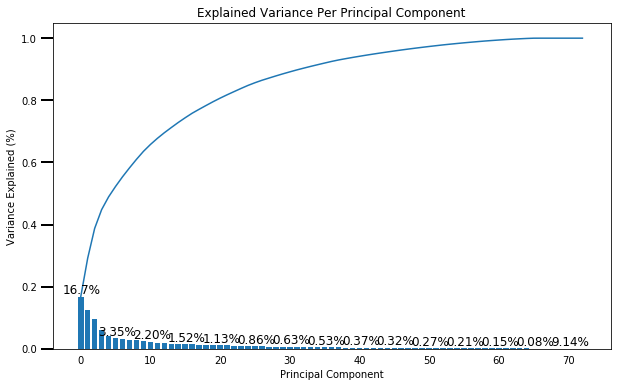

In [840]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    
    Credit:Udacity Nanodegree
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        if(i%5==0):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)

In [841]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=30)
azdias_low_pca = pca.fit_transform(azdias_low_dummies)

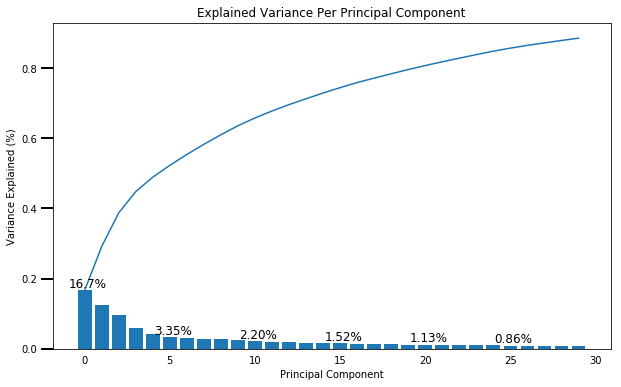

In [842]:
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

After performing PCA on my dataset, I finally to keep the number of components as 30 as the variance per principal component is very low after that.

### Step 2.3: Interpret Principal Components

Now that I have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, I'll map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- I'll then investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, I'll write a function that I can call at any time to print the sorted list of feature weights, for the *i*-th principal component. 

In [843]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def weights(nth_pc,pca,df):
    name_list=list(df.columns)
    weights_list=list(pca.components_[nth_pc])
    df =pd.DataFrame(list(zip(name_list, weights_list)))
    df.set_axis(['Feature', 'Weights'], axis=1, inplace=True)
    df = df.sort_values(by=['Weights'] , ascending=False)
    df.set_index('Feature', inplace=True)
    return df
    

In [844]:
weights(1,pca,azdias_low_dummies).head(10)

Weights
Feature                       
ALTERSKATEGORIE_GROB  0.258114
SEMIO_ERL             0.250297
FINANZ_VORSORGER      0.225519
SEMIO_LUST            0.180181
RETOURTYP_BK_S        0.153142
SEMIO_KRIT            0.141106
SEMIO_KAEM            0.134263
ANREDE_KZ_2           0.119939
W_KEIT_KIND_HH        0.106486
FINANZ_HAUSBAUER      0.102560

In [845]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights(2,pca ,azdias_low_dummies).head(10)

Weights
Feature                       
ANREDE_KZ_1           0.336667
SEMIO_VERT            0.316804
SEMIO_SOZ             0.230574
SEMIO_FAM             0.210211
SEMIO_KULT            0.189397
FINANZ_MINIMALIST     0.158973
RETOURTYP_BK_S        0.126226
FINANZ_VORSORGER      0.117838
ALTERSKATEGORIE_GROB  0.110962
W_KEIT_KIND_HH        0.095299

In [846]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights(3,pca,azdias_low_dummies).head(10)

Weights
Feature                      
GREEN_AVANTGARDE_1   0.357257
EWDICHTE             0.240388
ORTSGR_KLS9          0.235379
LP_LEBENSPHASE_FEIN  0.134216
LP_LEBENSPHASE_GROB  0.129473
ONLINE_AFFINITAET    0.128442
ANZ_PERSONEN         0.121848
SEMIO_DOM            0.112473
OST_WEST_KZ_W        0.108074
PLZ8_ANTG2           0.104757

### Discussion 2.3: Interpret Principal Components

I mapped each weight to their corresponding feature name and figured out the most interesting features for the first three principal components in this substep.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

I've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. 
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. 
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [847]:
# Over a number of different cluster counts...
average=[]
for i in range(15):
    if(i%2==0 and i!=0):
        # run k-means clustering on the data and...
        kmeans = KMeans(n_clusters=i).fit(azdias_low_dummies)
        # Obtain a score related to the model fit
        score = np.abs(kmeans.score(azdias_low_dummies))
        # compute the average within-cluster distances.
        print("For n_clusters={}, average within-cluster distances = {}".format(i,score/azdias_low_dummies.shape[0]))
        average.append(score/azdias_low_dummies.shape[0])

For n_clusters=2, average within-cluster distances = 63.812688919822804
For n_clusters=4, average within-cluster distances = 56.42108601616382
For n_clusters=6, average within-cluster distances = 52.21573948936118
For n_clusters=8, average within-cluster distances = 49.365735343352114
For n_clusters=10, average within-cluster distances = 46.50121785116316
For n_clusters=12, average within-cluster distances = 44.914120458107256
For n_clusters=14, average within-cluster distances = 43.98234381687299


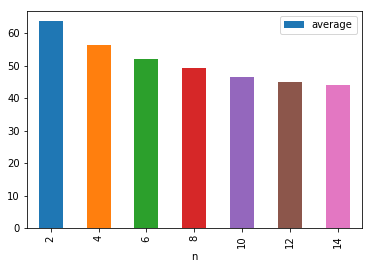

In [848]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
n=[2,4,6,8,10,12,14]
cluster_df =pd.DataFrame(list(zip(average,n)))
cluster_df.set_axis(['average', 'n'], axis=1, inplace=True)
cluster_df.plot.bar(x='n', y='average')

In [849]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_pred_general = KMeans(n_clusters=14).fit_predict(azdias_low_dummies)

### Discussion 3.1: Apply Clustering to General Population

I used sklearn's KMeans class to perform k-means clustering on the PCA-transformed data and finally fitted the k-means model with number of clusters as 14 after investigating the change in within-cluster distance accross number of clusters..

### Step 3.2: Apply All Steps to the Customer Data

Now that I have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Then I'll fit k-means model to the customer data with n_cluster=14. In the last step of the project, I will interpret how the general population fits apply to the customer data.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function I created earlier. 
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data.Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [850]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')
customers.shape

(191652, 85)

In [851]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_low_dummies=clean_data(customers)
customers_low_dummies.shape

(111919, 75)

In [852]:
# Apply feature scaling to the customer data.
#imputing missing values with the mode
customers_low_dummies[list(customers_low_dummies.columns)] = customers_low_dummies[list(customers_low_dummies.columns)].fillna(customers_low_dummies.mode().iloc[0])
scaler = StandardScaler()
customers_low_dummies[list(customers_low_dummies.columns)] = scaler.fit_transform(customers_low_dummies[list(customers_low_dummies.columns)])

In [853]:
# apply PCA to the customer data while selecting for number of components to retain.
pca1 = PCA(n_components=30)
customers_low_pca = pca1.fit_transform(customers_low_dummies)

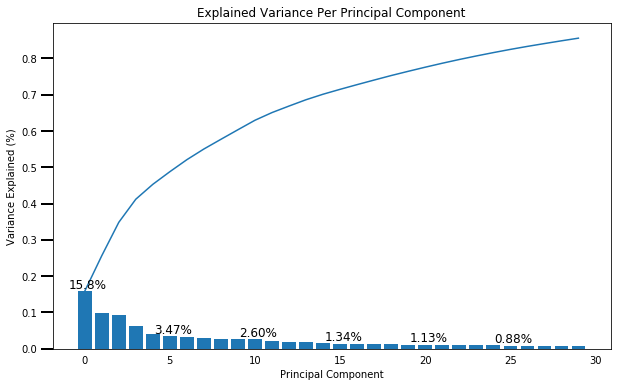

In [854]:
scree_plot(pca1)

In [855]:
# fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the customers data.

kmeans_pred_customers = KMeans(n_clusters=14).fit_predict(customers_low_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, I have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, I will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [856]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
from collections import Counter
Counter(kmeans_pred_general)

Counter({0: 48051,
         1: 48990,
         2: 59693,
         3: 58187,
         4: 48451,
         5: 45652,
         6: 54965,
         7: 55311,
         8: 42341,
         9: 58475,
         10: 51870,
         11: 5628,
         12: 50545,
         13: 38714})

In [857]:
Counter(kmeans_pred_customers)

Counter({0: 8148,
         1: 11098,
         2: 12665,
         3: 8988,
         4: 15318,
         5: 7561,
         6: 3744,
         7: 12334,
         8: 3354,
         9: 12116,
         10: 173,
         11: 5813,
         12: 1092,
         13: 9515})

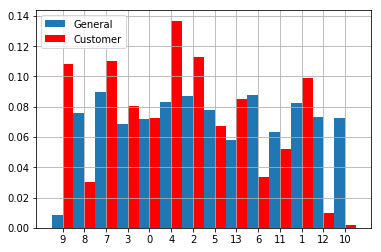

In [858]:
labels, values = zip(*Counter(kmeans_pred_customers).items())
v=list(values)
v[:] = [x/len(kmeans_pred_customers) for x in v]
indexes = np.arange(len(labels))
width = .5
labels1, values1 = zip(*Counter(kmeans_pred_general).items())
v1=list(values1)
v1[:] = [x/len(kmeans_pred_general) for x in v1]
indexes1 = np.arange(len(labels))
plt.bar(indexes1, v1, width ,label='General')
plt.bar(indexes+width, v, width,  color='r' , label='Customer')
plt.xticks(indexes + width * 0.5, labels)
plt.legend(loc='upper left')
plt.grid()
plt.show()

From the above plot, we can say that in 12,9,6,3,4 and 5 clusters, proportion of data  is underpresented for customer compared to general population **AND**  in 2,13,11,0 and 8 cluster, proportion of data is overpresented for customer compared to general population.

In [859]:
#Function for printing the top feature
def top_feature(cl_no,pca,df):
    print("Top feature for n_clusters:{}  is {} ".format(cl_no,weights(cl_no,pca,df).index[0]))

In [860]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
top_feature(2,pca1,customers_low_dummies)
top_feature(13,pca1,customers_low_dummies)
top_feature(11,pca1,customers_low_dummies)
top_feature(10,pca1,customers_low_dummies)
top_feature(8,pca1,customers_low_dummies)

Top feature for n_clusters:2  is SEMIO_REL 
Top feature for n_clusters:13  is ANZ_HH_TITEL 
Top feature for n_clusters:11  is VERS_TYP_2.0 
Top feature for n_clusters:10  is ANZ_HAUSHALTE_AKTIV 
Top feature for n_clusters:8  is SOHO_KZ_1.0 


>SEMIO_REL implies their Personality typology is high

>ANZ_HH_TITEL implies they have residential building

>VERS_TYP_2.0 implies they have high individualistic-accepting risks

>ANZ_HAUSHALTE_AKTIV implies higher Number of households in the building

>SOHO_KZ_1.0 implies small office/home office

In [861]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
top_feature(12,pca1,customers_low_dummies)
top_feature(9,pca1,customers_low_dummies)
top_feature(6,pca1,customers_low_dummies)
top_feature(3,pca1,customers_low_dummies)
top_feature(4,pca1,customers_low_dummies)
top_feature(5,pca1,customers_low_dummies)

Top feature for n_clusters:12  is ANZ_HH_TITEL 
Top feature for n_clusters:9  is OST_WEST_KZ_W 
Top feature for n_clusters:6  is KBA13_ANZAHL_PKW 
Top feature for n_clusters:3  is GREEN_AVANTGARDE_1 
Top feature for n_clusters:4  is LP_LEBENSPHASE_GROB 
Top feature for n_clusters:5  is VERS_TYP_1.0 


>ANZ_HH_TITEL implies they have high Number of professional academic title holders in building

>OST_WEST_KZ_W implies they belong to West

>KBA13_ANZAHL_PKW implies they have high Number of cars in the PLZ8 region

>GREEN_AVANTGARDE_1 implies they are member of green avantgarde

>LP_LEBENSPHASE_GROB implies they single low-income and average earners of younger age

> VERS_TYP_1.0 implies they are social-safety driven

### Discussion 3.3: Compare Customer Data to Demographics Data

This mail-order company is popular with those who have high individualistic-accepting risks, higher Number of households in the building, may have small home office and are young.


Whereas this mail-order company is less popular with those who have high Number of professional academic title, are single low-income and average earners of younger age,are member of green avantgarde and are social-safety driven